In [97]:
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.graph_objects as go

from statsmodels.graphics.tsaplots import month_plot
from statsmodels.tsa.seasonal import seasonal_decompose
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA


In [98]:
pd.set_option('display.float_format', lambda x: '{:,.2f}'.format(x))

In [99]:
sales_df = pd.read_csv("../data/daily_revenue.csv", 
                       parse_dates=["date"], 
                       index_col=["date"], 
                       dayfirst = True)

In [100]:
sales_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1795 entries, 2018-01-01 to 2022-11-30
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   revenue        1795 non-null   object
 1   discount_rate  1795 non-null   object
 2   coupon_rate    1795 non-null   object
dtypes: object(3)
memory usage: 56.1+ KB


In [101]:
sales_df.head()

,revenue,discount_rate,coupon_rate
date,,,
2018-01-01,"6,270,839",34.27%,1.09%
2018-01-02,"8,922,076",30.87%,1.08%
2018-01-03,"8,446,101",28.11%,1.01%
2018-01-04,"7,785,798",27.32%,0.96%
2018-01-05,"6,375,303",25.70%,0.90%


In [102]:
sales_df["revenue"] = sales_df["revenue"].str.replace(",", "").astype(float)
sales_df["discount_rate"] = sales_df["discount_rate"].str.replace("%", "").astype(float)
sales_df["coupon_rate"] = sales_df["coupon_rate"].str.replace("%", "").astype(float)

In [103]:
sales_df

,revenue,discount_rate,coupon_rate
date,,,
2018-01-01,"6,270,839.00",34.27,1.09
2018-01-02,"8,922,076.00",30.87,1.08
2018-01-03,"8,446,101.00",28.11,1.01
2018-01-04,"7,785,798.00",27.32,0.96
2018-01-05,"6,375,303.00",25.70,0.90
...,...,...,...
2022-11-26,"26,934,947.00",30.41,0.38
2022-11-27,"31,890,868.00",29.75,0.35
2022-11-28,"32,100,918.00",25.27,8.93


In [104]:
sales_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1795 entries, 2018-01-01 to 2022-11-30
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   revenue        1795 non-null   float64
 1   discount_rate  1795 non-null   float64
 2   coupon_rate    1795 non-null   float64
dtypes: float64(3)
memory usage: 56.1 KB


In [105]:
sales_df.describe()

,revenue,discount_rate,coupon_rate
count,"1,795.00","1,795.00","1,795.00"
mean,"11,884,191.07",18.31,0.86
std,"5,139,488.85",4.98,1.23
min,"3,820,099.00",7.93,0.18
25%,"8,372,375.50",14.39,0.32
50%,"11,163,501.00",17.68,0.47
75%,"14,396,680.50",21.76,0.79
max,"77,562,782.00",34.27,11.25


In [106]:
sales_df.isna().sum()

revenue          0
discount_rate    0
coupon_rate      0
dtype: int64

In [107]:
sales_df.loc[sales_df["revenue"].idxmax()]

revenue         77,562,782.00
discount_rate           32.02
coupon_rate              1.26
Name: 2021-11-26 00:00:00, dtype: float64

In [108]:
sales_df.loc[sales_df["revenue"].idxmin()]

revenue         3,820,099.00
discount_rate          22.24
coupon_rate             1.44
Name: 2018-12-31 00:00:00, dtype: float64

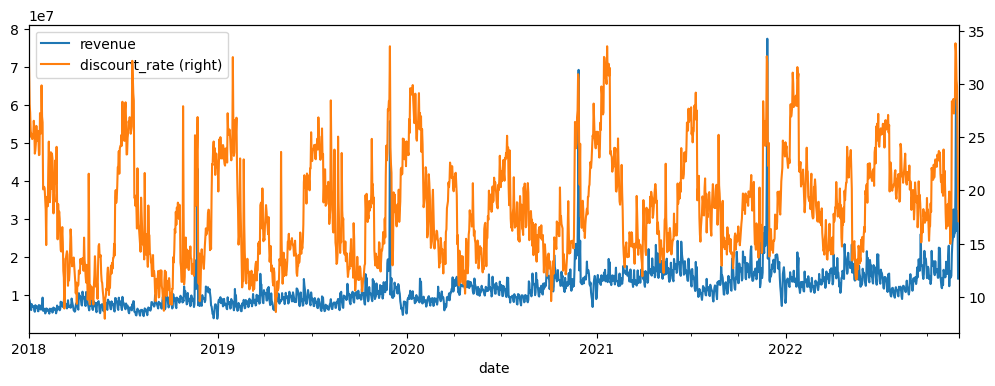

In [109]:
plt.figure(figsize=(12,4))
ax = sales_df["revenue"].plot(legend=True)
ax = sales_df["discount_rate"].plot(secondary_y=True, legend=True)
plt.show()

In [110]:
px.scatter(sales_df, x="revenue", y="discount_rate")

In [111]:
sales_df.resample("YE").agg(["mean", "sum"])

revenue                  discount_rate          coupon_rate  \
                    mean              sum          mean      sum        mean   
date                                                                           
2018-12-31  7,695,890.25 2,808,999,940.00         16.54 6,038.62        1.07   
2019-12-31  9,246,480.80 3,374,965,492.00         17.46 6,373.42        0.83   
2020-12-31 11,835,948.19 4,331,957,037.00         18.13 6,634.78        0.64   
2021-12-31 15,553,486.61 5,677,022,611.00         19.12 6,978.23        0.81   
2022-12-31 15,386,760.17 5,139,177,898.00         20.48 6,841.10        0.96   

                   
              sum  
date               
2018-12-31 389.44  
2019-12-31 302.05  
2020-12-31 234.74  
2021-12-31 295.05  
2022-12-31 321.49

In [112]:
month_sales_df = sales_df.resample("ME").agg(["mean", "sum"])
month_sales_df

revenue                discount_rate        coupon_rate      
                    mean            sum          mean    sum        mean   sum
date                                                                          
2018-01-31  6,897,600.42 213,825,613.00         25.49 790.21        1.59 49.14
2018-02-28  6,090,103.36 170,522,894.00         20.10 562.73        0.97 27.03
2018-03-31  7,329,328.84 227,209,194.00         13.72 425.19        1.60 49.73
2018-04-30  8,306,952.90 249,208,587.00         12.45 373.64        0.93 27.85
2018-05-31  7,292,738.90 226,074,906.00         11.30 350.28        0.79 24.52
2018-06-30  7,570,532.00 227,115,960.00         16.94 508.27        0.70 21.13
2018-07-31  6,707,990.03 207,947,691.00         24.63 763.68        1.76 54.64
2018-08-31  6,196,928.74 192,104,791.00         15.07 467.19        0.73 22.76
2018-09-30  8,058,145.77 241,744,373.00         10.98 329.39        1.27 38.02
2018-10-31  8,865,112.10 274,818,475.00         14.63 453.57        0.90 28.01
2018-11-30 10,575,425.83 317,262,775.00         15.05 451.39        0.58 17.39
2018-12-31  8,424,667.13 261,164,681.00         18.16 563.08        0.94 29.22
2019-01-31  7,846,647.45 243,246,071.00         24.11 747.36        0.73 22.65
2019-02-28  7,464,455.39 209,004,751.00         17.53 490.94        1.32 36.86
2019-03-31  9,039,179.90 280,214,577.00         13.73 425.64        0.96 29.75
2019-04-30  8,896,786.20 266,903,586.00         13.40 402.12        0.59 17.73
2019-05-31  9,176,974.45 284,486,208.00         14.27 442.51        0.52 16.08
2019-06-30  9,578,320.73 287,349,622.00         17.60 528.12        0.98 29.30
2019-07-31  7,722,037.19 239,383,153.00         22.95 711.47        1.12 34.66
2019-08-31  7,722,920.61 239,410,539.00         18.18 563.46        1.04 32.13
2019-09-30  9,746,084.77 292,382,543.00         13.23 396.79        0.42 12.54
2019-10-31 10,422,266.39 323,090,258.00         15.99 495.59        1.20 37.17
2019-11-30 13,753,225.67 412,596,770.00         18.24 547.29        0.53 16.03
2019-12-31  9,577,335.94 296,897,414.00         20.07 622.13        0.55 17.15
2020-01-31  9,442,137.06 292,706,249.00         26.65 826.29        1.25 38.72
2020-02-29  8,433,784.17 244,579,741.00         17.76 515.06        0.42 12.06
2020-03-31  9,606,225.52 297,792,991.00         17.13 531.06        0.99 30.57
2020-04-30 12,543,906.53 376,317,196.00         14.65 439.37        0.43 12.87
2020-05-31 11,604,141.26 359,728,379.00         15.33 475.28        0.40 12.26
2020-06-30 11,808,399.23 354,251,977.00         18.93 567.81        0.33 10.04
2020-07-31 10,358,588.42 321,116,241.00         20.26 628.21        0.63 19.40
2020-08-31 10,004,561.74 310,141,414.00         17.62 546.10        0.76 23.56
2020-09-30 12,562,371.30 376,871,139.00         14.75 442.50        0.68 20.39
2020-10-31 13,986,094.29 433,568,923.00         14.57 451.76        0.51 15.77
2020-11-30 18,319,739.63 549,592,189.00         19.02 570.57        0.87 26.05
2020-12-31 13,396,470.90 415,290,598.00         20.67 640.77        0.42 13.05
2021-01-31 14,425,610.55 447,193,927.00         27.64 856.91        0.90 28.04
2021-02-28 14,670,553.64 410,775,502.00         19.24 538.71        0.70 19.61
2021-03-31 14,478,946.65 448,847,346.00         14.86 460.56        0.29  9.04
2021-04-30 16,311,636.90 489,349,107.00         17.86 535.75        0.58 17.33
2021-05-31 16,595,986.10 514,475,569.00         15.37 476.55        0.53 16.30
2021-06-30 17,581,353.93 527,440,618.00         21.78 653.53        0.70 21.08
2021-07-31 12,338,371.23 382,489,508.00         21.99 681.61        1.01 31.34
2021-08-31 12,098,464.74 375,052,407.00         18.47 572.42        0.67 20.68
2021-09-30 13,810,407.23 414,312,217.00         14.97 449.09        1.00 29.99
2021-10-31 16,790,207.52 520,496,433.00         18.49 573.04        0.85 26.41
2021-11-30 21,947,358.77 658,420,763.00         19.98 599.55        1.29 38.58
2021-12-31 15,747,394.00 488,169,214.00         18.73 580.51       

In [113]:
px.line(month_sales_df["revenue"]["mean"])

In [114]:
px.line(sales_df["revenue"])

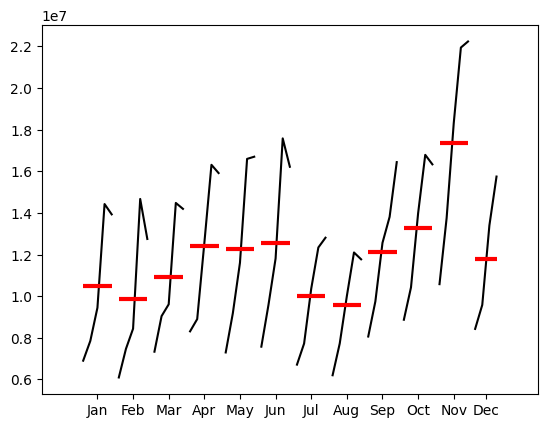

In [115]:
month_plot(sales_df["revenue"].resample("ME").mean())
plt.show()

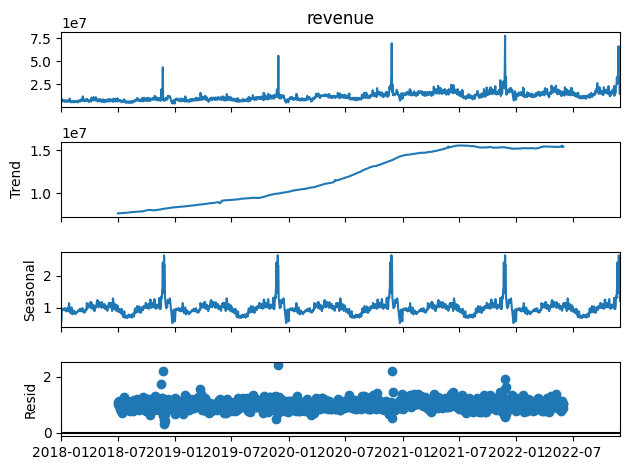

In [116]:
decomposition = seasonal_decompose(sales_df["revenue"], model="multiplicative", period=365)

fig = decomposition.plot()

In [117]:
sales_df = sales_df.asfreq("d")

In [118]:
periods = 30
train, test = sales_df.iloc[:-periods, 0], sales_df.iloc[-periods:, 0]

In [119]:
train_df = pd.DataFrame({
    "unique_id": "series1",
    "ds": train.index,    # datetime index
    "y": train.values     # target values
})

sarima_model = StatsForecast(models=[AutoARIMA(season_length=7)], freq='D')


In [120]:
sarima_model.fit(train_df)

StatsForecast(models=[AutoARIMA])

In [121]:
sarima_forecast = sarima_model.predict(h=30)  # forecast next n periods
sarima_pred = sarima_forecast.set_index("ds")["AutoARIMA"].reindex(test.index)


In [122]:
import numpy as np
import pandas as pd
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error

# --- Clean & freq ---
sales = sales_df.copy()
sales.index = pd.to_datetime(sales.index)
sales = sales.sort_index()
sales["revenue"] = sales["revenue"].astype(str).str.replace(",", "", regex=False).astype(float)
exog_cols = ["discount_rate", "coupon_rate"]
sales[exog_cols] = sales[exog_cols].astype(float)

freq = pd.infer_freq(sales.index) or "D"
sales = sales.asfreq(freq)

# --- Split ---
H = 30
train, test = sales.iloc[:-H], sales.iloc[-H:]
y_train, y_test = train["revenue"], test["revenue"]
X_train, X_test = train[exog_cols], test[exog_cols]

# --- Training DF (must have unique_id, ds, y, then exog) ---
train_long = pd.DataFrame({
    "unique_id": "series1",
    "ds": y_train.index,     # <-- ensure 'ds' present
    "y": y_train.values
})
# attach exog by aligning on index->ds
train_long = (
    train_long
    .set_index("ds")
    .join(X_train)          # joins on datetime index
    .reset_index()          # brings back 'ds'
)

# --- Future exog (must have unique_id, ds, and exog cols) ---
X_future = X_test.copy()
X_future["ds"] = X_test.index        # <-- ensure 'ds'
X_future.insert(0, "unique_id", "series1")
X_future = X_future.reset_index(drop=True)

# --- Forecast (no separate fit) ---
sf = StatsForecast(models=[AutoARIMA(season_length=7)], freq=freq)
fcst = sf.forecast(df=train_long, h=H, X_df=X_future)   # returns cols: unique_id, ds, AutoARIMA

# Align predictions to test index
sarimax_pred = fcst.set_index("ds")["AutoARIMA"].reindex(y_test.index)



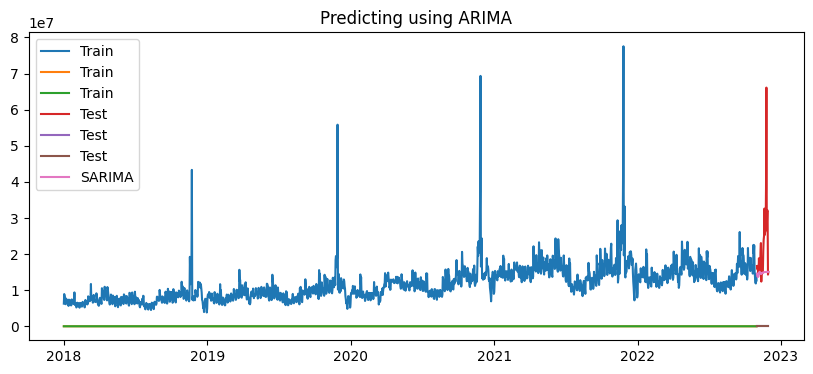

In [123]:
plt.figure(figsize=(10,4))
plt.plot(train, label = "Train")
plt.plot(test, label = "Test")
plt.plot(sarima_pred, label = "SARIMA")

plt.title("Predicting using ARIMA")
plt.legend()
plt.show()

In [ ]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=train.index, y=train, mode="lines", name="Train"))
fig.add_trace(go.Scatter(x=test.index, y=test, mode="lines", name="Test"))
fig.add_trace(go.Scatter(x=sarima_pred.index, y=sarima_pred, mode="lines", name="SARIMA"))
fig.add_trace(go.Scatter(x=sarimax_pred.index, y=sarimax_pred, mode="lines", name="SARIMAX"))


fig.update_layout(
    title="Predicting using Exponential Smoothing",
    xaxis_title="Date",
    yaxis_title="Value",
    legend=dict(x=0, y=1, traceorder="normal"),
    width=1000, height=400
)

fig.show()